In [1]:
import ceviche_challenges
from ceviche_challenges import units as u
from ceviche_challenges.model_base import _wavelengths_nm_to_omegas

from ceviche import viz, fdfd_ez
from ceviche import jacobian

import autograd
import autograd.numpy as npa
import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from inverse_design.brushes import notched_square_brush, circular_brush
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange

from javiche import jaxit

from inverse_design.local_generator import generate_feasible_design_mask
from jax.example_libraries.optimizers import adam

# Define the problem using ceviche_challenges

In [16]:
spec = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_2umx2um_spec(
    wg_width=400*u.nm, variable_region_size=(1600*u.nm, 1600*u.nm), cladding_permittivity=2.25
)
params = ceviche_challenges.waveguide_bend.prefabs.waveguide_bend_sim_params(resolution = 10 * u.nm,
                                                                             wavelengths=u.Array([1270], u.nm))
model = ceviche_challenges.waveguide_bend.model.WaveguideBendModel(params, spec)

# Define the optimization function

In [17]:
def db_to_au(x):
    return npa.power(10, x / 10)

S_cutoff_dB = npa.array([-20., -0.5])
S_cutoff = db_to_au(S_cutoff_dB)
g = npa.array([-1 if x < S_cutoff.max() else +1 for x in S_cutoff])
w_valid = npa.array([x if x < S_cutoff.max() else 1-x for x in S_cutoff])

min_w = jnp.min(w_valid)

In [18]:
def plot_state(model, rho, grads):
    des = forward(rho, brush)
    
    _, E_12 = model.simulate(des, excite_port_idxs=[0])
    _, E_21 = model.simulate(des, excite_port_idxs=[1])

    E_12 = E_12.squeeze()
    E_21 = E_21.squeeze()
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4))
    viz.abs(E_12, outline=model.density(des), ax=ax[0]);
    viz.abs(E_21, outline=model.density(des), ax=ax[1]);
    viz.real(grads, ax=ax[2]);
    ax[3].imshow(grads.T)
    #viz.real(ez_in * np.conj(ez_out), outline=model.density(np.asarray(design)), ax=ax[2]);
    #viz.real(ez_in * ez_out, outline=model.density(np.asarray(design)), ax=ax[3]);
    #viz.real((Ez_source.squeeze() * Ez_probe.squeeze()).T, outline=model.density(np.asarray(design)), ax=ax[4]);
    plt.show()

In [19]:
@jaxit()
def objective_S(rho):
    s_params, fields = model.simulate(rho)
    
    return s_params

def loss_function(S):
    s11 = jnp.abs(S[:, 0, 0])**2
    s21 = jnp.abs(S[:, 0, 1])**2

    s = jnp.stack((s11,s21))
    g = jnp.stack((jnp.ones_like(s11),-jnp.ones_like(s21)))

    t_s21 = 10**(-0.5/10)
    t_s11 = 10**(-20/10)

    target = jnp.stack((jnp.ones_like(s11)*(t_s11**2),jnp.ones_like(s21)*(t_s21**2)))
    w_min = min(1-t_s11, t_s21)
    L = jnp.sum(jax.nn.softplus(g*(s-target)/w_min)**2)
    
    return L

# Then, the inverse design aka the conditional generator part

In [20]:
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush, verbose=False)
    design = (design_mask+1.0)/2.0
    return design

In [27]:
brush = circular_brush(11)
latent = new_latent_design(model.design_variable_shape, bias=0.01, r=1, r_scale=1e-3)

In [28]:
def loss_fn(latent):
    design = forward(latent, brush)
    S = objective_S(design)
    return loss_function(S)

# Now we define the optimization

In [29]:
# Number of epochs in the optimization
Nsteps = 10
# Parameters for the Adam optimizer
step_size = 0.01
beta1 = 0.667
beta2 = 0.9

In [30]:
grad_fn = jax.grad(loss_fn)

init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(latent) #.flatten()
#value_and_grad seems to have a problem. Figure out why!

def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    grads = grad_fn(latent)
    loss = loss_fn(latent)

    optim_state = update_fn(step, grads, state)
    # optim_latent = params_fn(optim_state)
    # optim_latent = optim_latent/optim_latent.std()
    plot_state(model, latent, grads)
    
    return loss, optim_state

In [31]:
init_fn, update_fn, params_fn = adam(step_size, beta1, beta2)
state = init_fn(npa.array(latent))

latent = params_fn(state)
grads = grad_fn(jnp.array(latent))

  0%|          | 0/10 [00:00<?, ?it/s]

0


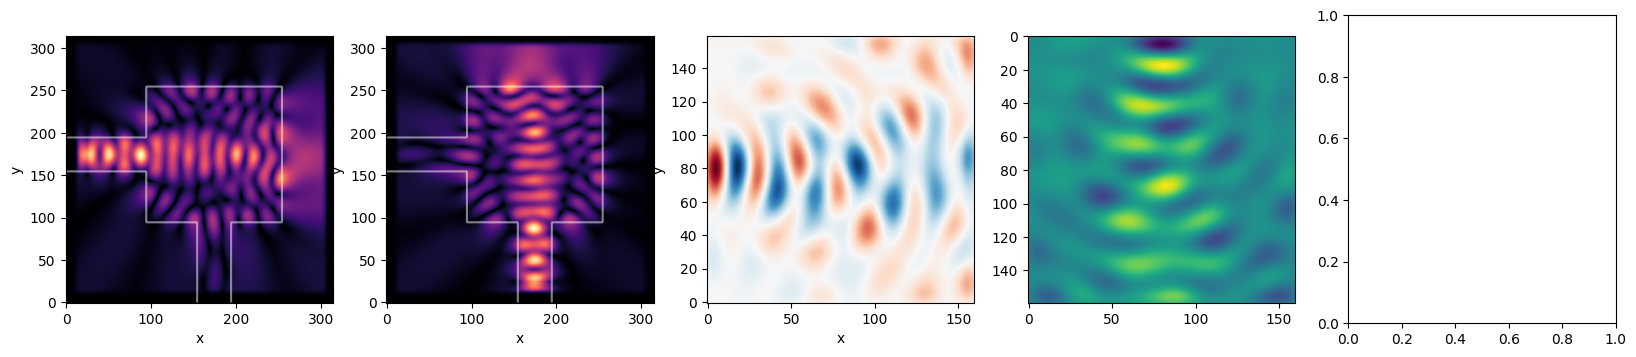

1


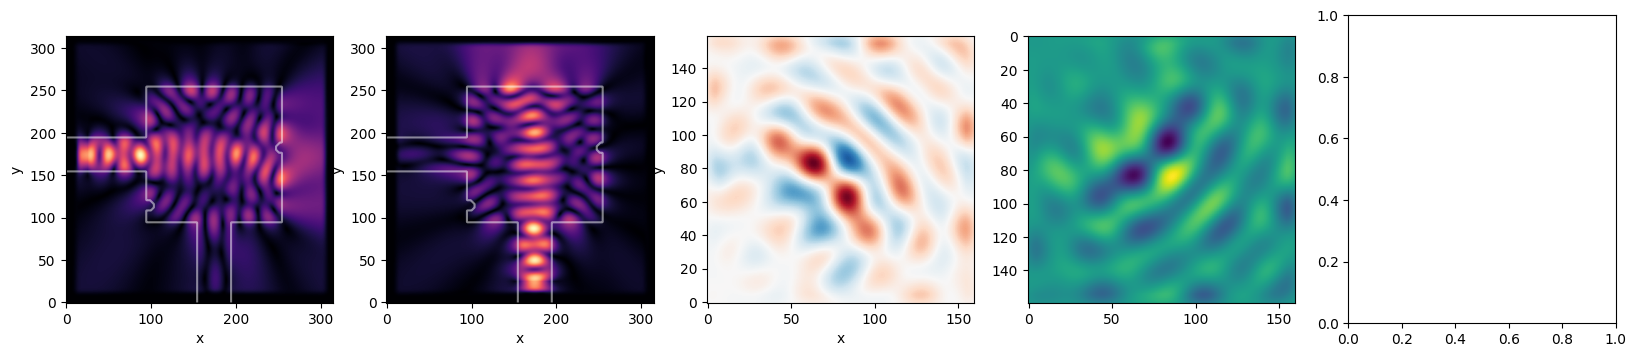

2


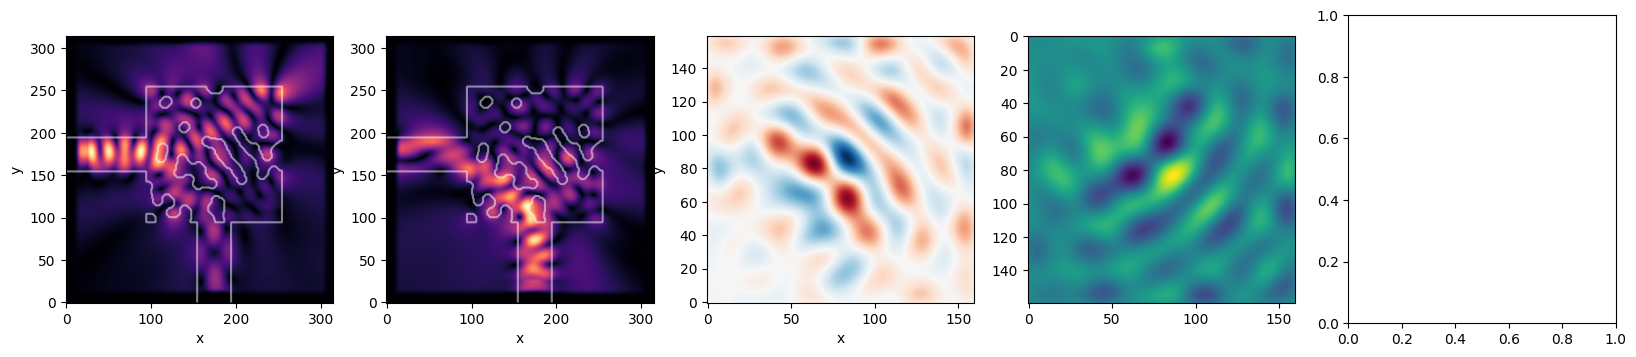

3


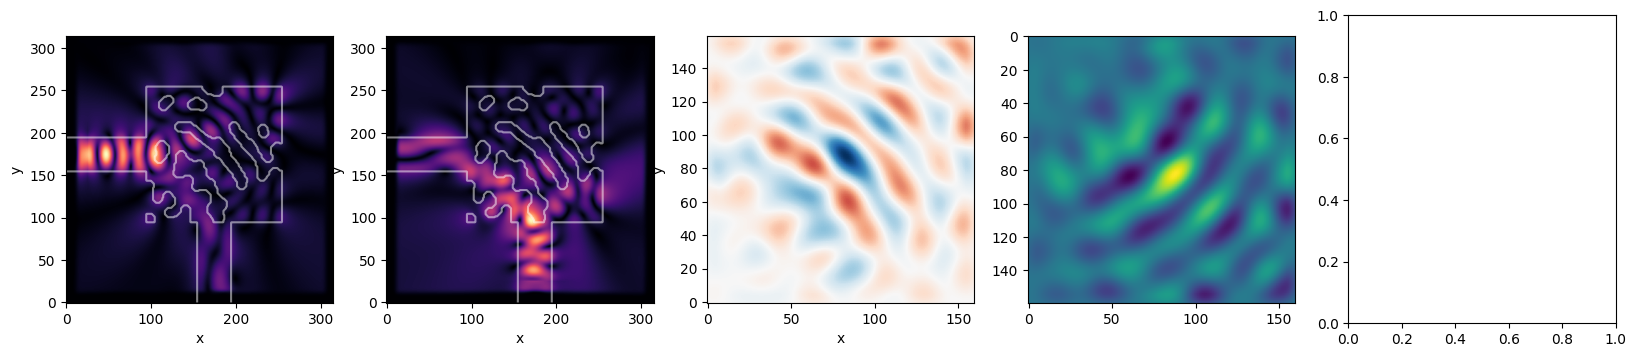

4


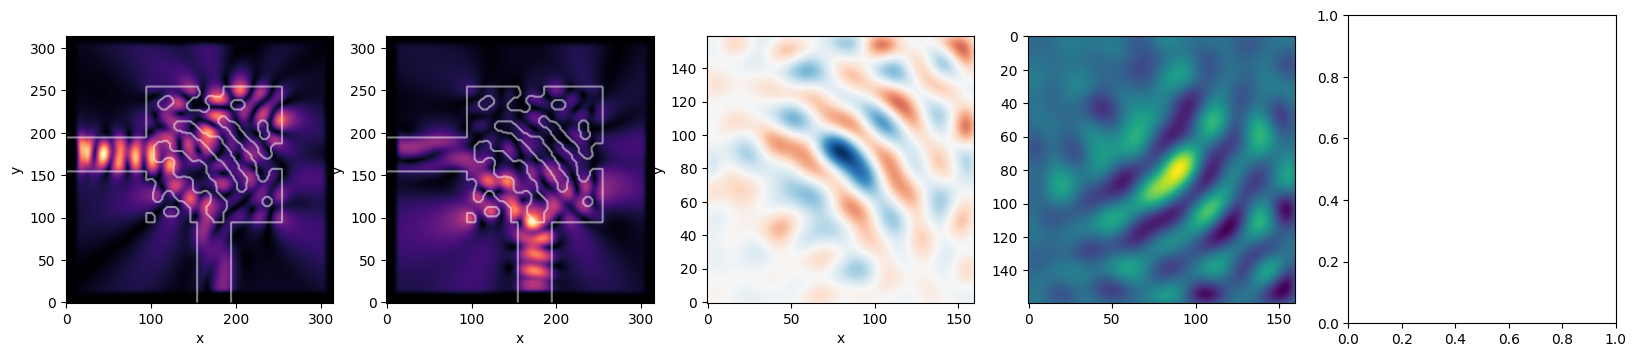

5


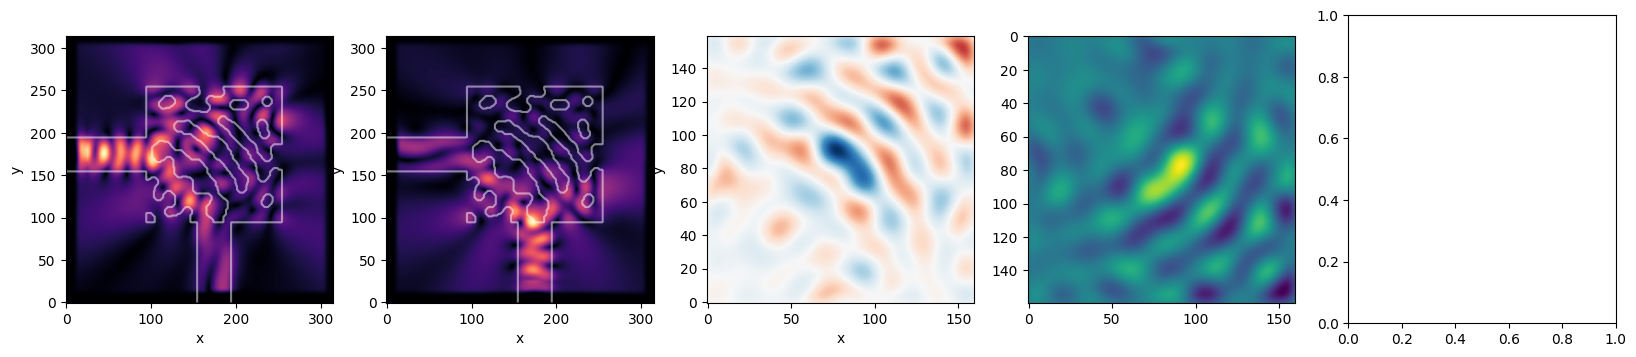

6


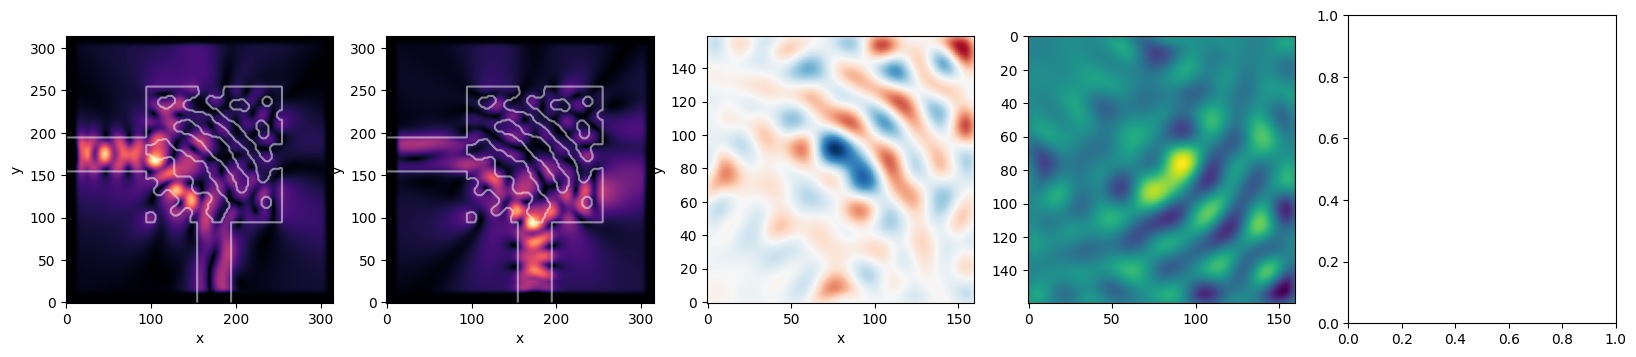

7


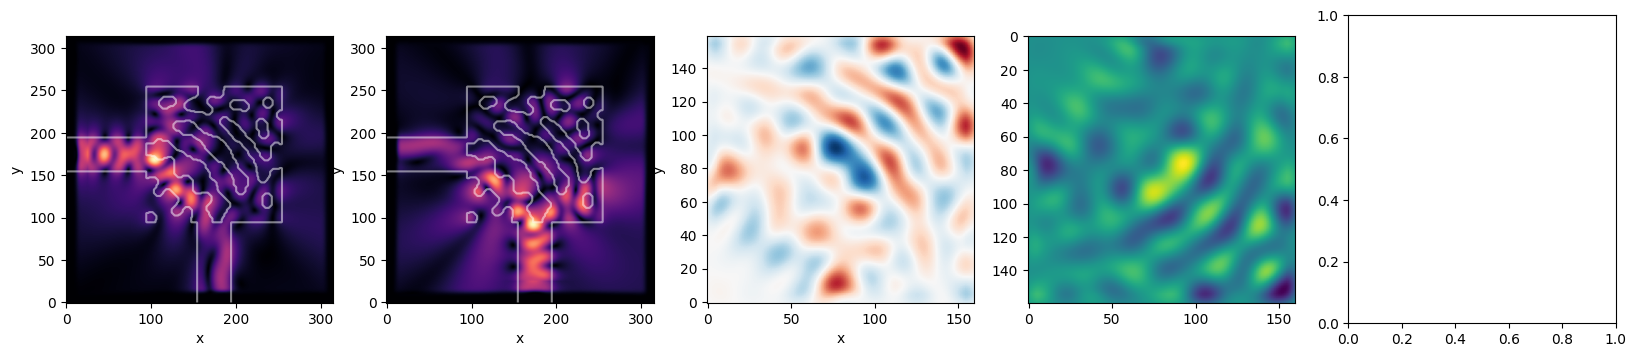

8


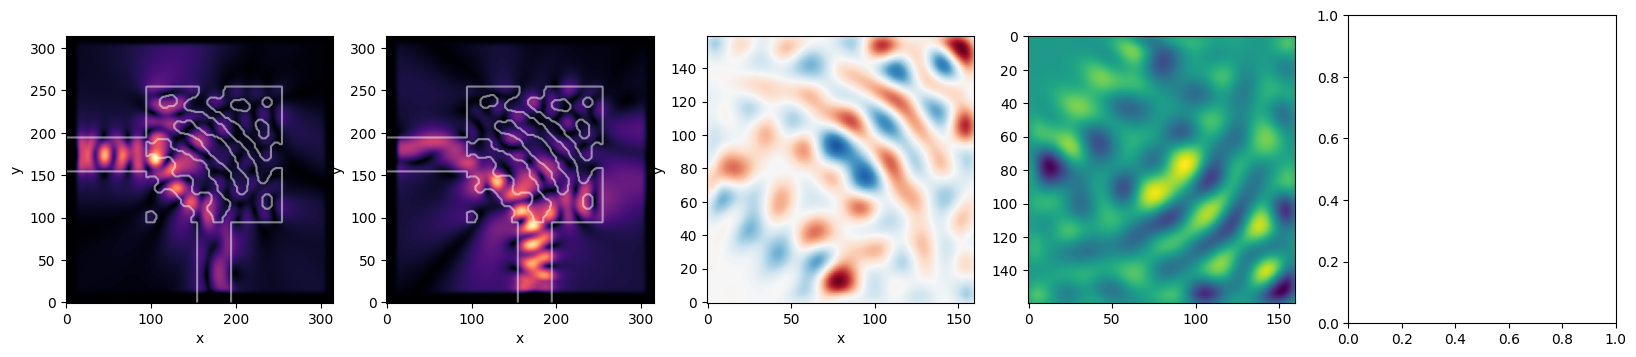

9


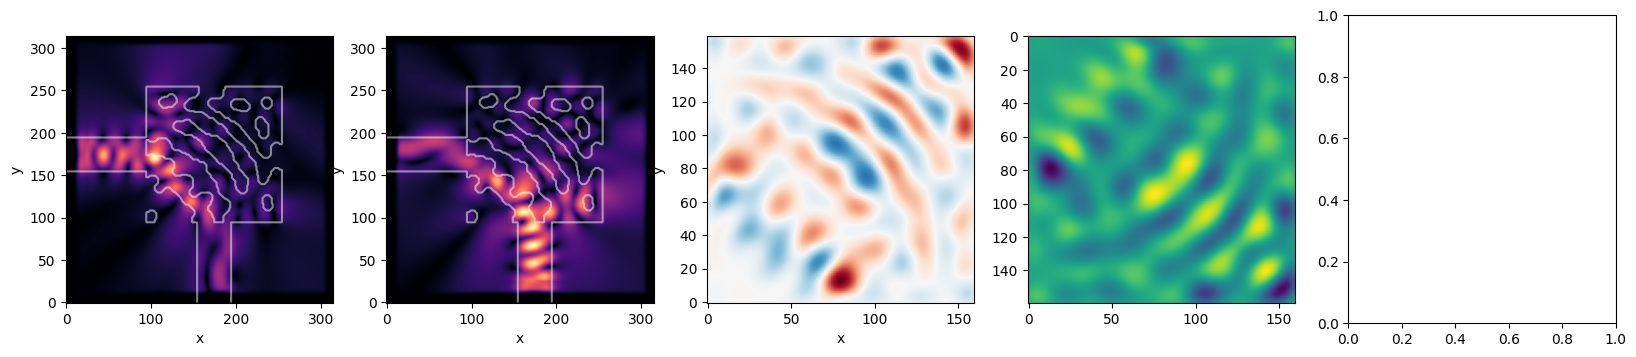

In [32]:
#|eval:false
range_ = trange(Nsteps)
losses = np.ndarray(Nsteps)
for step in range_:
    print(step)
    loss, state = step_fn(step, state)
    losses[step] = loss
    range_.set_postfix(loss=float(loss))

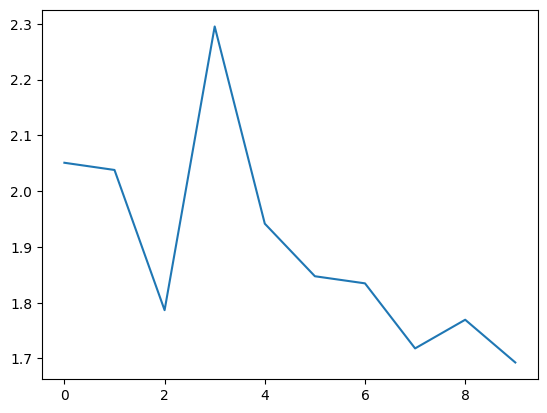

In [33]:
plt.plot(losses);